In [1]:
import mxnet as mx
import numpy as np
from mxnet import gluon

from cnnviz.layers import Activation, Conv2D
from cnnviz import cnnviz

from matplotlib import pyplot as plt

from alexnet import build_alexnet, preprocess

#Move this import elsewhere
import cv2

Build the network you want to visualize. Import `Activation` and `Conv2D` from `cnnviz.layers` instead of `gluon.nn`. Relu actvation has been modified to make negative gradients zero. `Conv2D` has been modified to record gradients of the output of the specified convolution layer.

In [2]:
import os
from mxnet.gluon.model_zoo import model_store

from mxnet.gluon.nn import MaxPool2D, Flatten, Dense, Dropout
from cnnviz.layers import Activation, Conv2D

class AlexNet(mx.gluon.HybridBlock):
    def __init__(self, classes=1000, **kwargs):
        super(AlexNet, self).__init__(**kwargs)
        with self.name_scope():
            self.features = gluon.nn.HybridSequential(prefix='')
            with self.features.name_scope():
                self.features.add(Conv2D(64, kernel_size=11, strides=4, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(192, kernel_size=5, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(384, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Flatten())

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

            self.output = Dense(classes)

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

def build_alexnet(pretrained=False, ctx=mx.cpu(),
            root=os.path.join('~', '.mxnet', 'models'), **kwargs):
    net = AlexNet(**kwargs)
    if pretrained:
        net.load_params(model_store.get_model_file('alexnet', root=root), ctx=ctx)
    return net

def preprocess(data):
    #data = mx.image.imresize(data, 256, 256)
    #data, _ = mx.image.center_crop(data, (224, 224))
    data = mx.image.imresize(data, 224, 224)
    data = data.astype(np.float32)
    data = data/255
    data = mx.image.color_normalize(data,
                                    mean=mx.nd.array([0.485, 0.456, 0.406]),
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    data = mx.nd.transpose(data, (2,0,1))
    return data


Instantiate the network. Read the image you want to use for visualization.

In [3]:
alexnet = build_alexnet(pretrained=True)

imgpath = "img/cat_dog.png"
with open(imgpath, 'rb') as fp:
    str_image = fp.read()

image = mx.img.imdecode(str_image)
image = preprocess(image)
image = image.expand_dims(axis=0)

### Guided GRAD-CAM

In [4]:
last_conv_layer_name = 'alexnet0_conv2d4'

imggrad = cnnviz.get_image_grad(alexnet, image)
conv_out, conv_out_grad = cnnviz.get_conv_out_grad(alexnet, image, conv_layer_name=last_conv_layer_name)

weights = np.mean(imggrad, axis=(1, 2))

cam = np.ones(conv_out.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * conv_out[i, :, :]

cam = cv2.resize(cam, (224, 224)) #Get the image size as argument
cam = np.maximum(cam, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam)) 
cam = np.uint8(cam * 255)

ggcam = np.multiply(cam, imggrad)

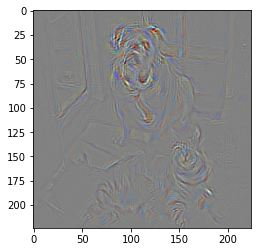

In [7]:
img = cnnviz.grad_to_image(imggrad)
plt.imshow(img)

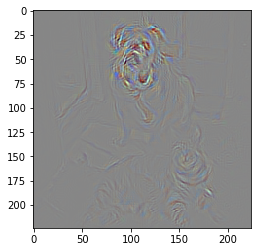

In [5]:
img = cnnviz.grad_to_image(ggcam)
plt.imshow(img)

### GRAD-CAM Heatmap

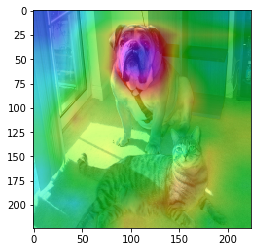

In [6]:
def get_img_heatmap(org_img, activation_map):

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_HSV)
    org_img = cv2.resize(org_img, (224, 224)) #Get image size as argument

    img_heatmap = np.float32(heatmap) + np.float32(org_img)
    img_heatmap = img_heatmap / np.max(img_heatmap)

    return img_heatmap

orig_img = cv2.imread(imgpath)
img = get_img_heatmap(orig_img, cam)
plt.imshow(img)

### Guided GRAD-CAM Saliency

In [ ]:
def to_grayscale(cv2im):
    grayscale_im = np.sum(np.abs(cv2im), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

ggcam_gray = to_grayscale(ggcam)
img = np.squeeze(cnnviz.grad_to_image(ggcam_gray))
plt.imshow(img, cmap='gray')

### Combined

In [ ]:
def get_cam(imggrad, conv_out):
    weights = np.mean(imggrad, axis=(1, 2))

    cam = np.ones(conv_out.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_out[i, :, :]

    cam = cv2.resize(cam, (imggrad.shape[1], imggrad.shape[2]))
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam)) 
    cam = np.uint8(cam * 255)
    return cam

def get_guided_grad_cam(cam, imggrad):
    return np.multiply(cam, imggrad)

def get_img_heatmap(orig_img, activation_map):
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_HSV)
    orig_img = cv2.resize(orig_img, (orig_img.shape[0], orig_img.shape[1]))

    img_heatmap = np.float32(heatmap) + np.float32(orig_img)
    img_heatmap = img_heatmap / np.max(img_heatmap)

    return img_heatmap

def to_grayscale(cv2im):
    grayscale_im = np.sum(np.abs(cv2im), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

def visualize_class_activation(net, normalized_img, orig_img, conv_layer_name):
    # Returns grad-cam heatmap, guided grad-cam, guided grad-cam saliency
    imggrad = cnnviz.get_image_grad(alexnet, image)
    conv_out, conv_out_grad = cnnviz.get_conv_out_grad(alexnet, image, conv_layer_name=last_conv_layer_name)

    cam = get_cam(imggrad, conv_out)
    
    ggcam = get_guided_grad_cam(cam, imggrad)
    img_ggcam = cnnviz.grad_to_image(ggcam)
    
    img_heatmap = get_img_heatmap(orig_img, cam)
    
    ggcam_gray = to_grayscale(ggcam)
    img_ggcam_gray = np.squeeze(cnnviz.grad_to_image(ggcam_gray))
    
    return img_heatmap, img_ggcam, img_ggcam_gray

#oi = cv2.resize(orig_img, image.shape)
orig_img = cv2.imread(imgpath)
last_conv_layer_name = 'alexnet0_conv2d4'
viz_images = visualize_class_activation(alexnet, image, orig_img, last_conv_layer_name)

In [ ]:
plt.imshow(viz_images[0])

In [ ]:
plt.imshow(viz_images[1])

In [ ]:
plt.imshow(viz_images[2], cmap='gray')